In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import sys
import copy
import time

def readCloud(path,name):
    print("Reading Cloud titled: '" + name+"'.")
    pcd = o3d.io.read_point_cloud(path+name, remove_nan_points=True)
    print(pcd) if len(np.asarray(pcd.points)) > 0 else print("PointCloud empty.")
    return pcd

def colorInlierOutlier(fullCloud,indices):
    Inlier=fullCloud.select_by_index(indices)
    Inlier.paint_uniform_color([.8,.8,.8]) # light grey
    Outlier=fullCloud.select_by_index(indices,invert=True)
    Outlier.paint_uniform_color([1,0,0]) # pure red
    ColoredCloud=Inlier+Outlier # re-combine both clouds to one output
    print("Inlier: ")
    print(Inlier)
    print("Outlier: ")
    print(Outlier)
    return ColoredCloud

def cloudVisualizer(cloud,name,winDims,viewCtrl,normalTF):
    visual=o3d.visualization.Visualizer()
    visual.create_window(window_name=name,width=winDims[0],height=winDims[1],visible=True)
    for c in cloud:
        visual.add_geometry(c)
        
    renderOpts=visual.get_render_option()
    renderOpts.show_coordinate_frame=True
    rgb=np.asarray([53,57,62])
    renderOpts.background_color=rgb/255
    renderOpts.point_size=2
    if normalTF == 0:
        renderOpts.point_show_normal=True
    else:
        renderOpts.point_show_normal=False
        
    view_ctrl=visual.get_view_control()
    view_ctrl.set_up(viewCtrl[0:3])
    view_ctrl.set_front(viewCtrl[3:6])
    view_ctrl.set_lookat(viewCtrl[6:9])
    view_ctrl.set_zoom(viewCtrl[9])
    
    visual.run()
    visual.destroy_window()
    print("Viewer '"+name+"' terminated.")

def keypoints2spheres(keypoints,radius,color):
    spheres = o3d.geometry.TriangleMesh()
    for i in keypoints.points:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
        sphere.translate(i)
        spheres += sphere
    spheres.paint_uniform_color((color)/255)
    return spheres

def progressbar(it, pf="", s=60, out=sys.stdout):
    ct = len(it)
    def show(j):
        x = int(s*j/ct)
        tmp=" "
        print(f"{pf}[{u'█'*x}{('.'*(s-x))}] {j}/{ct} {tmp}", end='\r', file=out, flush=True)
    show(0.1) # avoid div/0 
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)
    
def timerPrint(tic,toc):
    elapsed = 1000 * (toc - tic) # Calculate duration, translate to [ms]
    print("Complete after {:.0f} [ms].".format(elapsed))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
pc_in =  "data/input data/"   
pc_out = "data/output data/"  
filename = "conferenceRoom_1_rgb.ply"

winDims=[1000,800]
viewCtrl=[ -0.10, -0.10, 0.99, 0.32,  0.94, 0.13, -4.01, 0.03, -0.42, 0.38]

In [3]:
# Load Pointcloud
cloud_in = readCloud(pc_in,filename)

Reading Cloud titled: 'conferenceRoom_1_rgb.ply'.
PointCloud with 134536 points.


In [4]:
# downsampling
nthPoint = 1

print("Downsampling" + " with n = " + str(nthPoint) + ". ")
tic=time.time()

#global_shift = np.array([-691278.95,-5338139.89, -500])
#cloud_copy.translate(global_shift)

nth_Point_cloud = cloud_in.uniform_down_sample(nthPoint)


toc=time.time()
timerPrint(tic,toc)

o3d.io.write_point_cloud(pc_out+"downsampling.ply", nth_Point_cloud)
#viewTitle = "Uniform Downsampling with n = " + str(nthPoint)
#cloudVisualizer(nth_Point_cloud,viewTitle,winDims,viewCtrl,1)

Downsampling with n = 1. 
Complete after 29 [ms].


True

In [5]:
# outlier removal
minPoints = 20   
sphereRadius = 0.5

print("With a max Radius of " + str(sphereRadius) + " and a minimum point count of " + str(minPoints) + ". ")
tic=time.time()

ROR_c,ROR_indices = nth_Point_cloud.remove_radius_outlier(minPoints,sphereRadius)

toc=time.time()
timerPrint(tic,toc)

ROR_Cloud = colorInlierOutlier(nth_Point_cloud,ROR_indices)
o3d.io.write_point_cloud(pc_out+"outlier.ply", ROR_Cloud)

With a max Radius of 0.5 and a minimum point count of 20. 
Complete after 2580 [ms].
Inlier: 
PointCloud with 134536 points.
Outlier: 
PointCloud with 0 points.


True

[[-0.09015789 -0.15283383 -0.98413077]
 [ 0.12346994  0.92212084 -0.36667197]
 [ 0.05642276  0.99752683 -0.04191305]
 ...
 [ 0.99527219 -0.08248083 -0.05128535]
 [ 0.97592542 -0.19795725 -0.09155602]
 [ 0.91232972 -0.40938821  0.00746829]]


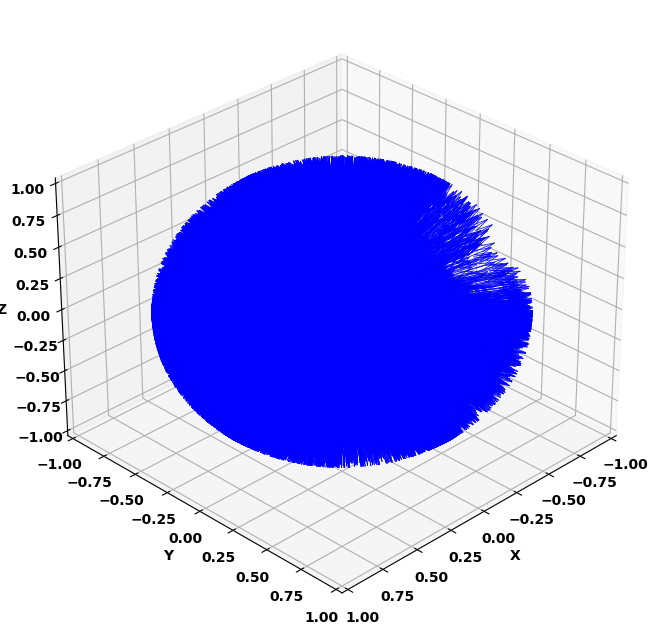

In [6]:
# Estimate Normals
ROR_Cloud.paint_uniform_color([0,0,1])
ROR_Cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=100))
normals = np.asarray(ROR_Cloud.normals)

print(normals)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

origin = np.zeros_like(normals)

ax.quiver(
    origin[:, 0], origin[:, 1], origin[:, 2],  
    normals[:, 0], normals[:, 1], normals[:, 2],  
    length=1.0, 
    color='blue', arrow_length_ratio=0.1, linewidth=0.5
)

ax.view_init(elev=30, azim=45)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [7]:
from sklearn.cluster import DBSCAN

eps = 0.01 
min_samples = 25  

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(normals)
labels = dbscan.labels_

print("Clustering labels:", labels)

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  
colors = np.random.rand(num_clusters + 1, 3)  

point_colors = np.array([colors[label] if label != -1 else [0, 0, 0] for label in labels])
ROR_Cloud.colors = o3d.utility.Vector3dVector(point_colors)

# visualization
o3d.io.write_point_cloud(pc_out+"normal_clustering.ply", ROR_Cloud)

viewTitle = "Normal Vector Clustering"
cloudVisualizer([ROR_Cloud],viewTitle,winDims,viewCtrl,1)

Clustering labels: [-1 -1 -1 ... -1 -1 -1]
Viewer 'Normal Vector Clustering' terminated.


In [8]:
def region_growing(pcd, labels, class_label, distance_threshold=0.3, normal_angle_threshold=15):
    points = np.asarray(pcd.points)
    normals = np.asarray(pcd.normals)

    # get points from of same label classified by normal vector clustering
    indices = np.where(labels == class_label)[0]
    sub_points = points[indices]
    sub_normals = normals[indices]

    kdtree = o3d.geometry.KDTreeFlann(pcd)

    visited = set()
    regions = []

    for idx in indices:
        if idx in visited:
            continue

        region = []
        stack = [idx]

        while stack:
            current_idx = stack.pop()
            if current_idx in visited:
                continue
            visited.add(current_idx)
            region.append(current_idx)

            _, neighbors, _ = kdtree.search_radius_vector_3d(pcd.points[current_idx], distance_threshold)

            for neighbor_idx in neighbors:
                if neighbor_idx in visited:
                    continue
                if labels[neighbor_idx] != class_label:
                    continue

                angle = np.degrees(np.arccos(
                    np.dot(pcd.normals[current_idx], pcd.normals[neighbor_idx])
                ))
                if angle < normal_angle_threshold:
                    stack.append(neighbor_idx)

        if len(region) > 10:  # ignore small areas
            regions.append(region)

    return regions

# region growing for each class
all_regions = {}
for class_label in range(num_clusters):
    regions = region_growing(ROR_Cloud, labels, class_label)
    all_regions[class_label] = regions

num_points = len(ROR_Cloud.points)
colors = np.zeros((num_points, 3))  
np.random.seed(42)  # ensure repetitive result

for class_label, regions in all_regions.items():
    for region in regions:
        region_color = np.random.rand(3) 
        colors[region] = region_color

ROR_Cloud.colors = o3d.utility.Vector3dVector(colors)

# visulization
# viewTitle = "Normal Vector Clustering 2"
# cloudVisualizer([ROR_Cloud],viewTitle,winDims,viewCtrl,1)

o3d.io.write_point_cloud(pc_out+"normal_clustering_2.ply", ROR_Cloud)

C:\Users\SEVEN\AppData\Local\Temp\ipykernel_9368\3533043413.py:37: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(


True